#### Install dependent packages

In [ ]:
!pip install cufflinks
!jupyter nbextension enable --py --sys-prefix widgetsnbextension
!pip install -U sentence-transformers
!git clone https://github.com/UKPLab/sentence-transformers.git
!pip install torch==1.3.1+cpu torchvision==0.4.2+cpu -f https://download.pytorch.org/whl/torch_stable.html
!pip install plotly==4.4.1

#### this code is using the following:

- Sentence Embeddings using BERT - https://github.com/UKPLab/sentence-transformers
- JR/Paul Shapiro google nlp cloud scripts - https://opensource.com/article/19/7/python-google-natural-language-api
And a few more super smart stuff! like clustering, dimensionality reduction algorithems and keyword extraction.

notice:
you need to get a services.json file see JR/Paul Shapiro google nlp cloud scripts.
this code can use txt file or url as input.
BERTs memory requirement grows quadratic with the length of the sentence / document. Therefore, there is a limit of 512 tokens. As many words are broken down into sub-tokens, you often can only encode texts with up to 300-400 words with BERT.In general I think BERT is the wrong choice for documents. BERT is strong on a sentence level, but it will not produce sensible results on a document level.

do you want to use URL ? enter yes/Yesyes
insert project name   jer
insert url   https://en.wikipedia.org/wiki/Jerusalem
getting text
document lenght:  90535
proccesing text
creating embeddings
reducing embeddings dimensions
ploting...


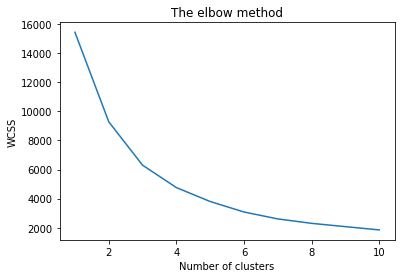

insert number of topics   12


sentences distribution plot:





topics volume
:


entities/salience from google nlp service:





the sentences@topics:





interactive(children=(Dropdown(description='column', options=('label',), value='label'), IntSlider(value=10, d…



keyword summarization of sentences above / what are the topics about:





,topic 11,topic 10,topic 9,topic 8,topic 7,topic 6,topic 5,topic 4,topic 3,topic 2,topic 1,topic 0
0,jerusalem,jerusalem,jerusalem,jerusalem,city,%,jerusalem,jerusalem,jerusalem,jerusalem,jerusalem,jerusalem
1,city,city,city,university,jerusalem,jerusalem,israel,city,city,israel,city,city
2,israel,israel,%,center,jews,population,city,judea,station,city,al,israel
3,tech,temple,jews,art,israel,city,states,al,bus,east,temple,east
4,mediterranean,bce,population,hebrew,residents,jews,east,rule,tel,annexation,mount,war
5,residents,mount,percent,israel,quarter,schools,capital,ce,buildings,population,period,west
6,festival,david,israel,museum,palestine,percentage,.,church,aviv,areas,bce,jordan
7,business,century,°,institutions,site,children,tel,christians,central,minister,century,al
8,theater,hebrew,force,music,testament,haredi,ministry,bce,building,palestine,king,capital
9,industries,capital,years,world,inhabitants,year,president,century,.,capital,stone,state


In [6]:
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
import re
from goose3 import Goose
import pandas as pd
from nltk.tokenize import sent_tokenize
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import plotly
import plotly.graph_objects as go
from google.cloud import language
from google.oauth2 import service_account
from google.cloud.language import enums
from google.cloud.language import types
from google.cloud import language
import os
from goose3 import Goose
import pandas as pd
import argparse
from collections import OrderedDict
import numpy as np
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt

nlp = spacy.load('en_core_web_sm')
embedder = SentenceTransformer('bert-base-nli-stsb-mean-tokens')

class TextRank4Keyword():
    """Extract keywords from text"""
    
    def __init__(self):
        self.d = 0.85 # damping coefficient, usually is .85
        self.min_diff = 1e-5 # convergence threshold
        self.steps = 10 # iteration steps
        self.node_weight = None # save keywords and its weight

    
    def set_stopwords(self, stopwords):  
        """Set stop words"""
        for word in STOP_WORDS.union(set(stopwords)):
            lexeme = nlp.vocab[word]
            lexeme.is_stop = True
    
    def sentence_segment(self, doc, candidate_pos, lower):
        """Store those words only in cadidate_pos"""
        sentences = []
        for sent in doc.sents:
            selected_words = []
            for token in sent:
                # Store words only with cadidate POS tag
                if token.pos_ in candidate_pos and token.is_stop is False:
                    if lower is True:
                        selected_words.append(token.text.lower())
                    else:
                        selected_words.append(token.text)
            sentences.append(selected_words)
        return sentences
        
    def get_vocab(self, sentences):
        """Get all tokens"""
        vocab = OrderedDict()
        i = 0
        for sentence in sentences:
            for word in sentence:
                if word not in vocab:
                    vocab[word] = i
                    i += 1
        return vocab
    
    def get_token_pairs(self, window_size, sentences):
        """Build token_pairs from windows in sentences"""
        token_pairs = list()
        for sentence in sentences:
            for i, word in enumerate(sentence):
                for j in range(i+1, i+window_size):
                    if j >= len(sentence):
                        break
                    pair = (word, sentence[j])
                    if pair not in token_pairs:
                        token_pairs.append(pair)
        return token_pairs
        
    def symmetrize(self, a):
        return a + a.T - np.diag(a.diagonal())
    
    def get_matrix(self, vocab, token_pairs):
        """Get normalized matrix"""
        # Build matrix
        vocab_size = len(vocab)
        g = np.zeros((vocab_size, vocab_size), dtype='float')
        for word1, word2 in token_pairs:
            i, j = vocab[word1], vocab[word2]
            g[i][j] = 1
            
        # Get Symmeric matrix
        g = self.symmetrize(g)
        
        # Normalize matrix by column
        norm = np.sum(g, axis=0)
        g_norm = np.divide(g, norm, where=norm!=0) # this is ignore the 0 element in norm
        
        return g_norm

    
    def get_keywords(self, number=10):
        """Print top number keywords"""
        node_weight = OrderedDict(sorted(self.node_weight.items(), key=lambda t: t[1], reverse=True))
        KW_List=[]
        for i, (key, value) in enumerate(node_weight.items()):
            KW_List.append(key)          
            if i > number:
                break
        return KW_List
        
    def analyze(self, text, 
                candidate_pos=['NOUN', 'PROPN'], 
                window_size=4, lower=False, stopwords=list()):
        """Main function to analyze text"""
        
        # Set stop words
        self.set_stopwords(stopwords)
        
        # Pare text by spaCy
        doc = nlp(text)
        
        # Filter sentences
        sentences = self.sentence_segment(doc, candidate_pos, lower) # list of list of words
        
        # Build vocabulary
        vocab = self.get_vocab(sentences)
        
        # Get token_pairs from windows
        token_pairs = self.get_token_pairs(window_size, sentences)
        
        # Get normalized matrix
        g = self.get_matrix(vocab, token_pairs)
        
        # Initionlization for weight(pagerank value)
        pr = np.array([1] * len(vocab))
        
        # Iteration
        previous_pr = 0
        for epoch in range(self.steps):
            pr = (1-self.d) + self.d * np.dot(g, pr)
            if abs(previous_pr - sum(pr))  < self.min_diff:
                break
            else:
                previous_pr = sum(pr)

        # Get weight for each node
        node_weight = dict()
        for word, index in vocab.items():
            node_weight[word] = pr[index]
        
        self.node_weight = node_weight

def analyze_entities(text, encoding='UTF32'):
    document = language.types.Document(content=text, language='en',type='PLAIN_TEXT')
    response = client.analyze_entities(document=document,encoding_type='UTF32')
    return response

def entity_create_list(text):
    entity_list = []
    entities = analyze_entities(text)
    for x in entities.entities:
        entity_list.append({ "name": x.name, "salience": x.salience, "entity_type": str(enums.Entity.Type(x.type)).strip('Type.')})
    return entity_list

def create_score(x, y):
    return x * y
use_url=input('do you want to use URL ? enter yes/Yes')
just_domain=input('insert project name   ')
if use_url == 'yes' or use_url == 'Yes':
    url=input('insert url   ')
    g = Goose({'browser_user_agent': 'Mozilla'})
    article = g.extract(url=url)
    df=article.cleaned_text
    df=sent_tokenize(df)
    print('getting text')
else:
    print('paste the text in "txt" file text.txt located in the folder and press enter when ready')
    ready=input('press enter to continue')
    file = open('text.txt', 'r',encoding="utf8") 
    df=file.read()
    df=sent_tokenize(df)
    url=just_domain
df1=df
df_len = ', '.join(df1)
df_len = len(df_len)
print('document lenght:  '+str(df_len))
df=[re.sub(r'\[[^()]*\]', '', i) for i in df] 
df=[re.sub('^\n', '', i) for i in df]
df=[re.sub('^\n', '', i) for i in df]
df=[re.sub('• ', '', i) for i in df]
df=[ i for i in df1 if len(i) >= 50 ]
print('proccesing text')
corpus_embeddings = embedder.encode(df)
print('creating embeddings')
# Initialize t-SNE
tsne = TSNE(n_components = 2, init = 'random', random_state = 10, perplexity = 100)
# Use only 400 rows to shorten processing time
tsne_df = tsne.fit_transform(corpus_embeddings)
print('reducing embeddings dimensions')
print('==============================')
print('ploting...')
x = tsne_df
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
    kmeans.fit(x)
    wcss.append(kmeans.inertia_)
#Plotting the results onto a line graph, allowing us to observe 'The elbow'
plt.plot(range(1, 11), wcss)
plt.title('The elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS') #within cluster sum of squares
plt.show()
n_clusters=input('insert number of topics   ')
print('')
print('')
#Applying kmeans to the dataset / Creating the kmeans classifier
kmeans = KMeans(n_clusters = int(n_clusters), init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
y_kmeans = kmeans.fit_predict(x)
y_kmeans1=pd.DataFrame(y_kmeans)
y_kmeans1=y_kmeans1.rename(columns={0:"label"})
# Append words to list
tsne_df1=pd.DataFrame(tsne_df)
tsne_df1=tsne_df1.join(y_kmeans1)
df=pd.DataFrame(df)
df=df.rename(columns={0:'text'})
tsne_df1=tsne_df1.join(df)
tsne_df1.to_csv(just_domain+'_sentences.csv')
fig = go.Figure(data=go.Scatter(x=tsne_df1[0],
                                y=tsne_df1[1],
                                textfont=dict(
                                family="sans serif",
                                size=8),
                                text=tsne_df1['text'],
                                hovertemplate=
                                "<b>Topic: %{marker.color}</b><br><br>" +
                                "Text: %{text}<br>" +
                                "<extra></extra>",
                                marker=dict(
                                color=tsne_df1['label'],   
                                colorbar=dict(
                                title="Topics"),
                                colorscale="Viridis"),
                                 mode='markers'))
fig.update_traces(textposition='top center')
fig.update_layout(title='A')
fig.update_layout(showlegend=False)
plotly.offline.plot(fig, filename = just_domain+'_sentences.html', auto_open=False)
print('\033[1;31msentences distribution plot:\033[0m\r\n')
fig.show()
n_clusters=int(n_clusters)
topic_volume1=pd.DataFrame()
Dict1={}
KW_List1=pd.DataFrame()
for n in range(n_clusters):
    n=int(n)
    to_extraction=tsne_df1.text.loc[tsne_df1['label']==int(n)].values
    to_extraction= ', '.join(to_extraction)
    text=to_extraction
    tr4w = TextRank4Keyword()
    tr4w.analyze(text, candidate_pos = ['NOUN', 'PROPN'], window_size=4, lower=True)
    KW_List=tr4w.get_keywords(50)
    KW_List=pd.DataFrame(KW_List,columns=['topic  '+str(n)])
    to_extraction_len = len(to_extraction)
    df_len = ', '.join(df1)
    df_len = len(df_len)
    topic_volume=(to_extraction_len/df_len)*100
    topic_volume=round(int(topic_volume),0)*1
    Dict = {'topic  '+str(n): to_extraction_len}
    Dict1={**Dict,**Dict1}
    #topic_volume=pd.DataFrame(Dict,index=[0]).T.reset_index().rename(columns={'index':'topic'+str(n),0:'volume'})
    KW_List1=KW_List.join(KW_List1)
    #topic_volume1=topic_volume.append(topic_volume1)

lenghts=pd.DataFrame(Dict1,index=[0]).T.reset_index().rename(columns={'index':'topic',0:'len'})
topic_volume=pd.DataFrame(Dict1,index=[0]).T.reset_index().rename(columns={'index':'topics',0:'volume'})
topic_volume.head(30)
labels = lenghts['topic']
values = lenghts['len']
fig = go.Figure(data=[go.Pie(labels=labels, values=values)])
print('')
print('')
print('\033[1;31mtopics volume\033[0m\r\n:')
fig.show()
KW_List1.to_csv(just_domain+'_words.csv')
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] =  'services.json'
credentials = service_account.Credentials.from_service_account_file(
'services.json')
client = language.LanguageServiceClient(credentials=credentials)
client = language.LanguageServiceClient()
text=entity_create_list(str(df1))
text = entity_df = pd.DataFrame.from_dict(text)
entity_df = entity_df.groupby(["name", 'entity_type'], as_index=False)["salience"].agg({"standev_salience": "std", "sum_salience": "sum", "median_salience": "median", "avg_salience": "mean", "count": "count"}).sort_values(by="count", ascending=False).reset_index()
entity_df['score'] = entity_df.apply(lambda row: create_score(row['avg_salience'], row['count']), axis=1)
entity_df['url'] = url
entity_df.sort_values(by="score", ascending=False).head()
fig = go.Figure(data=[go.Scatter(
x=entity_df['avg_salience'], y=entity_df['score'],
mode='markers',
text=entity_df['name']+'@'+entity_df['entity_type'],
marker=dict(size=12))])
fig.update_layout(
xaxis_title="avg salience",
yaxis_title="score",)
print('\033[1;31mentities/salience from google nlp service:\033[0m\r\n')
fig.show()
print('')
print('')
print('\033[1;31mthe sentences@topics:\033[0m\r\n')
print('')
print('')
@interact
def show_articles_more_than(column=['label'], 
                            lower=(0, 20, 1)):
    return tsne_df1[(tsne_df1[column] == lower)]
pd.set_option('max_colwidth', 8000)
print('')
print('')
print('\033[1;31mkeyword summarization of sentences above / what are the topics about:\033[0m\r\n')
print('')
print('')
KW_List1